In [255]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

from multiprocessing import process
import csv
from sklearn import tree



filterwarnings('ignore')

#Processing Class

In [256]:
class processing_data:
  def __init__(self,base,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to float
                    # If the column is not already of type object (string),
                    # convert it first before applying string operations.
                    X[column] = X[column].astype(str).str.replace(',', '.').astype(float) # Use X instead of self.base
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to float. Skipping...")

        return X


  def int_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to int
                    #X[column] = X[column].astype(int)
                    X[column]=pd.to_numeric(X[column], errors='coerce').astype(int) #changed column to X[column]
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to int. Skipping...")

        return X


  #if my target is a text I transform in dummy value
  #def target_variable(self,X,variavel):
  #  keys = list(self.base[variavel].unique())
  #  my_dict = {}

 #   for i, key in enumerate(keys):
 #     my_dict[key] = i
 #   self.base[variavel] = self.base[variavel].map(my_dict)
 #   return self.base,my_dict

  def target_variable(self,X,variavel,target, multiclass):
    if multiclass == False:
      self.base[variavel] = np.where(self.base[variavel]==target, 1, 0)
      return self.base
    else:
      keys = list(self.base[variavel].unique())
      my_dict = {}

      for i, key in enumerate(keys):
       my_dict[key] = i
      self.base[variavel] = self.base[variavel].map(my_dict)
      #with open('list_variables_markers.txt', 'w') as file:
      # file.write(my_dict)

      # open file for writing, "w" is writing
      w = csv.writer(open("output.csv", "w"))
      # loop over dictionary keys and values
      for key, val in my_dict.items():
      # write every key and value to file
        w.writerow([key, val])
      return self.base


  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X,variavel):
    #Normalize the data
    column_to_move = X.pop(variavel)
    X[variavel] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            # Reshape the output of fit_transform to match the number of columns
            imputed_data = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])
            # Create a DataFrame with the imputed values and correct columns
            #Instead of using X_df.columns[missing_cols_indices] I use X_df.columns[missing_cols_indices].to_list() for creating the dataframe
            imputed_df = pd.DataFrame(imputed_data, columns=X_df.columns[missing_cols_indices].to_list(), index=X_df.index) # Changed this line
            # Update the original DataFrame with the imputed values
            X_df.update(imputed_df)

        return X_df

#Models Class Multclass

In [257]:
class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()
    self.l_encode = LabelEncoder()
    self.l_encode.fit(np.unique(y))

  def neuro_model_multiclass(self): # Move this function outside __init__
    num_neu= len(self.Lista_variaveis)
    #targ=2
    ocult_neu=int((num_neu*(2/3))+2)
    # Get the number of unique classes in the target variable
    num_classes = self.y.shape[1]  # Assuming self.y is one-hot encoded
    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              # Change the output layer to have num_classes units
                              tf.keras.layers.Dense(num_classes, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro

  def tree_and_random_forest(self):
    #Decission Tree Model
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameters',clf.best_params_['criterion'],clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameters',clf_rf.best_params_['n_estimators'],clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):

    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameters',knn.best_params_)
    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f


  def models_metrics_neuro_multiclass(self, model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test):
    # Fit the model
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)

    pred = model.predict(Xtest)
    pred_ = np.argmax(pred, axis=1) # Get the predicted class labels directly from 'pred'
    pred_ = l_encode_test.inverse_transform(pred_) # Use the encoder from 'encode_target'
    true_y =l_encode_test.inverse_transform(np.argmax(ytest, axis=1)) # Correctly decode ytest

    scores = model.evaluate(Xtest, ytest)
    print(f'Test Loss: {scores[0]}')
    print(f'Test Accuracy: {scores[1]}')
    print('\n')
    f1 = f1_score(pred_, true_y, average="weighted")
    print(f'F1 Score: {f1}')
    print('\n')

    # Calculate permutation feature importance using the scoring function
    result = permutation_importance(
        model, Xtest, true_y, n_repeats=10, random_state=0, scoring=self.scoring_fn_multclass
    )
    # Create a DataFrame to store the results
    feature_importances = pd.DataFrame(
        {
            "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
            "importance": result.importances_mean,
        }
    ).sort_values("importance", ascending=False)


    print('\n',feature_importances)

    print('Confussion Matrix')
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(true_y, pred_))
    cmp.plot(ax=ax,cmap='inferno')
    plt.show()

  def scoring_fn_multclass(self, model, X, y):
    y_pred = model.predict(X, verbose=0)  # Get predicted probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

    # Check if y is already in the correct shape
    if y.ndim == 2 and y.shape[1] > 1:  # If y is one-hot encoded
        y_true_classes = np.argmax(y, axis=1)
    else:  # If y is not one-hot encoded
        y_true_classes = y  # or use your desired method to get true classes

    return accuracy_score(y_true_classes, y_pred_classes)

  def metrics_class(self,model, Xtrain, ytrain, Xtest, ytest,type_model):
     if type_model =='Decission Tree' or type_model =='Random Forest':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax,cmap = 'inferno')
        plt.show()
        print('\n Feature Importance')
        feature_importances = pd.DataFrame(model.feature_importances_,
                                                  index =self.Lista_variaveis,
                                                    columns=['importance']).sort_values('importance',ascending=False)
        print(feature_importances.count())
        feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
        graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )
        if type_model =='Decission Tree':
          tree.plot_tree(model.fit(Xtrain,ytrain))
        return

     elif type_model == 'KNN':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax, cmap='inferno')
        plt.show()
        print('\n KNN model does not have feature importance') # Print message instead of accessing feature_importances_
        return
     else:
        print('Model not found, Please Try Again With the Correct Model Type')

#Application

In [258]:
Dataset =pd.read_csv ("brca_metabric_clinical_data.tsv", sep = '\t') # pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')


In [259]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2509 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 12  ER Status                       24

In [260]:
Dataset.describe()

Age at Diagnosis       Cohort  Neoplasm Histologic Grade  \
count       2498.000000  2498.000000                2388.000000   
mean          60.420300     2.900320                   2.412060   
std           13.032997     1.962216                   0.649363   
min           21.930000     1.000000                   1.000000   
25%           50.920000     1.000000                   2.000000   
50%           61.110000     3.000000                   3.000000   
75%           70.000000     4.000000                   3.000000   
max           96.290000     9.000000                   3.000000   

       Lymph nodes examined positive  Mutation Count  \
count                    2243.000000     2358.000000   
mean                        1.950513        5.590755   
std                         4.017774        3.989171   
min                         0.000000        1.000000   
25%                         0.000000        3.000000   
50%                         0.000000        5.000000   
75%                         2.000000        7.000000   
max                        45.000000       81.000000   

       Nottingham prognostic index  Overall Survival (Months)  \
count                  2287.000000                1981.000000   
mean                      4.028787                 125.244271   
std                       1.189092                  76.111772   
min                       1.000000                   0.000000   
25%                       3.048000                  60.866667   
50%                       4.044000                 116.466667   
75%                       5.040000                 185.133333   
max                       7.200000                 355.200000   

       Relapse Free Status (Months)  Number of Samples Per Patient  \
count                   2388.000000                         2509.0   
mean                     110.293649                            1.0   
std                       77.539698                            0.0   
min                        0.000000                            1.0   
25%                       41.100000                            1.0   
50%                      100.416667                            1.0   
75%                      169.875000                            1.0   
max                      389.333333                            1.0   

       TMB (nonsynonymous)   Tumor Size  Tumor Stage  
count          2509.000000  2360.000000  1788.000000  
mean              6.849746    26.220093     1.713647  
std               5.320394    15.370883     0.655307  
min               0.000000     1.000000     0.000000  
25%               3.922553    17.000000     1.000000  
50%               6.537589    22.410000     2.000000  
75%               9.152624    30.000000     2.000000  
max             104.601416   182.000000     4.000000

#Some Checks

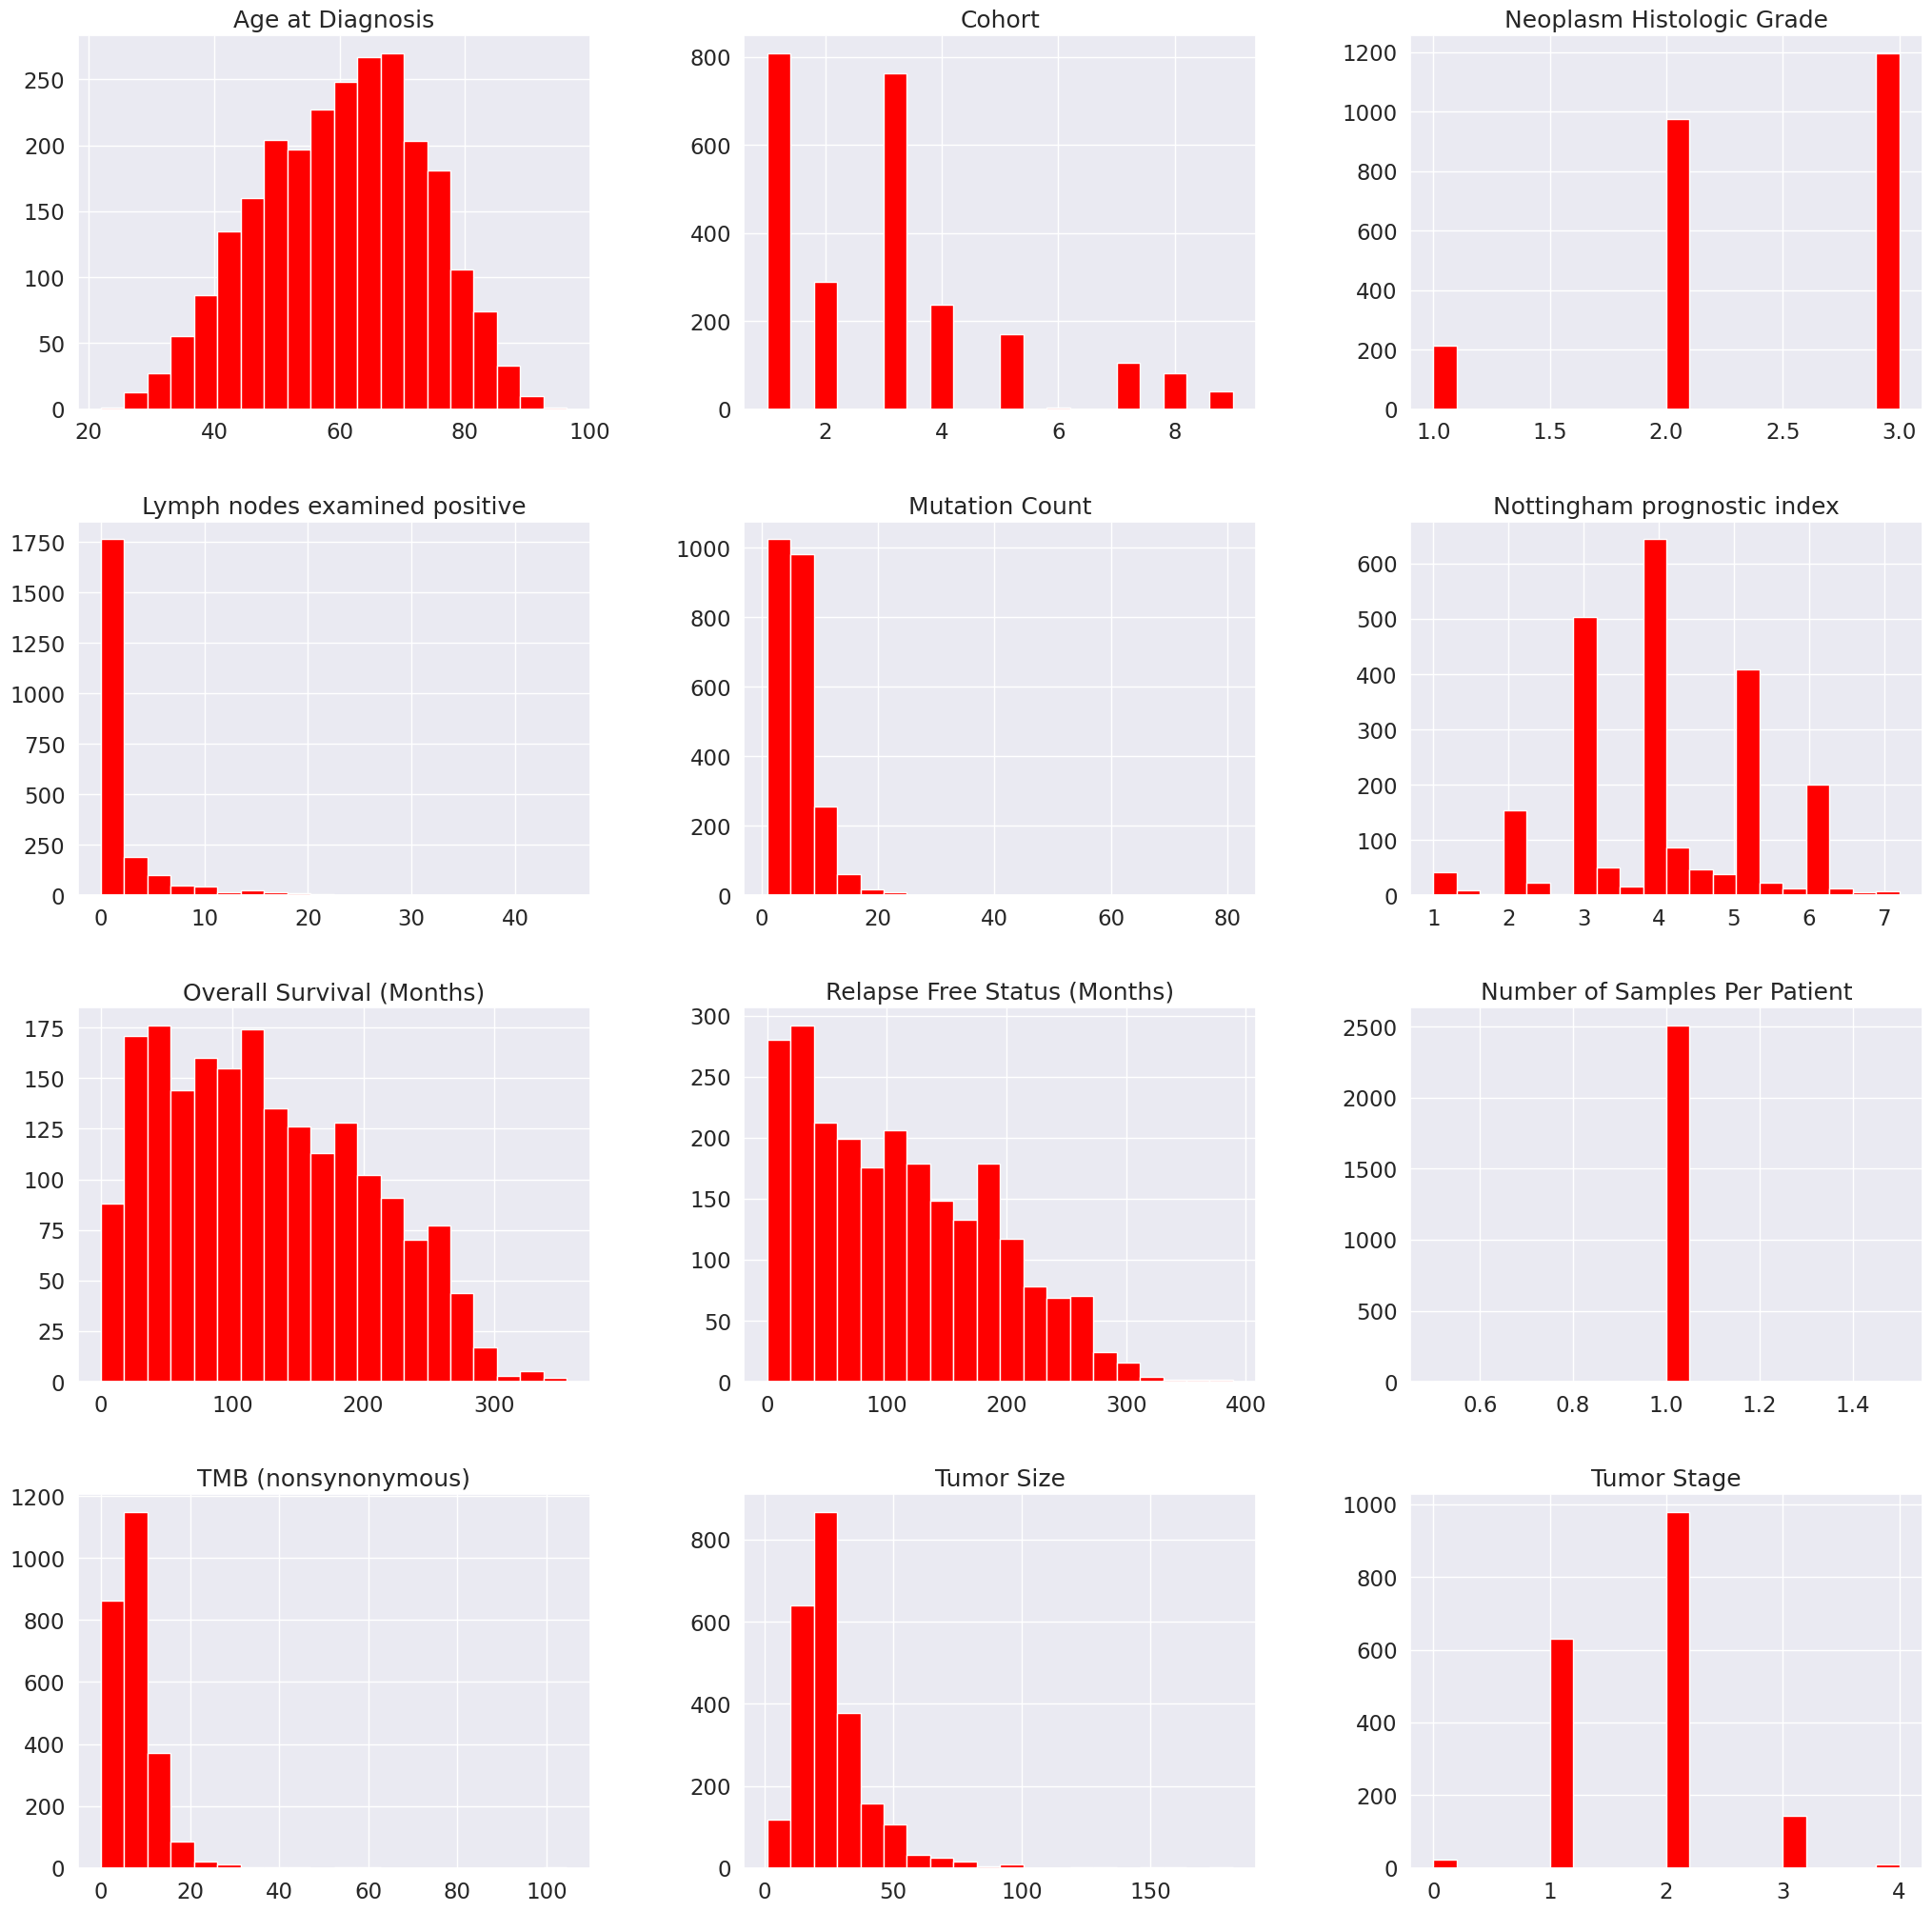

In [261]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

In [262]:
Dataset = Dataset.rename(columns={"Patient's Vital Status": "Patients Vital Status"})
Dataset_validation=Dataset[Dataset["Patients Vital Status"].isnull()]
Dataset=Dataset[Dataset["Patients Vital Status"].notnull()]


In [263]:
percent_missing=num = (Dataset.isna().sum()/len(Dataset))*100
print(percent_missing[percent_missing > 20].index)

Index(['Tumor Stage'], dtype='object')


#Variable Processing

In [264]:
list_to_drop=['Study ID','Patient ID','Sample ID',
              'Type of Breast Surgery','Cancer Type',
              'Tumor Other Histologic Subtype',
              'Relapse Free Status (Months)',
              'Relapse Free Status',
              'Sample Type','Sex','Cohort'
              ]
list_to_drop_percentage=percent_missing[percent_missing > 20].index
Dataset.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset.drop(list_to_drop,axis=1,inplace=True)

processor = processing_data(base=Dataset.copy())
variavel='Patients Vital Status'
target='Died of Disease'
type_method='mean'
dummies=list(Dataset.select_dtypes(include=['object']).columns)
dummies.remove('Patients Vital Status')
var_int=['Tumor Purity']
multiclass=True

In [265]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980 entries, 0 to 1984
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age at Diagnosis               1980 non-null   float64
 1   Cancer Type Detailed           1980 non-null   object 
 2   Cellularity                    1916 non-null   object 
 3   Chemotherapy                   1979 non-null   object 
 4   Pam50 + Claudin-low subtype    1979 non-null   object 
 5   ER status measured by IHC      1937 non-null   object 
 6   ER Status                      1980 non-null   object 
 7   Neoplasm Histologic Grade      1892 non-null   float64
 8   HER2 status measured by SNP6   1979 non-null   object 
 9   HER2 Status                    1979 non-null   object 
 10  Hormone Therapy                1979 non-null   object 
 11  Inferred Menopausal State      1979 non-null   object 
 12  Integrative Cluster            1979 non-null   object

In [267]:
main_pipeline=Pipeline([
                        #('int_values', FunctionTransformer(processor.int_values,
                        #                    kw_args={'str_var': var_int},
                        #                    validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),
                        ])

# Fit and transform the data using the pipeline
transformed_data = main_pipeline.fit_transform(Dataset)
X=processor.impute_values(transformed_data,type_method)
X,y,Lista_variaveis=processor.normalize_df(X,variavel)

#Check Metrics

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

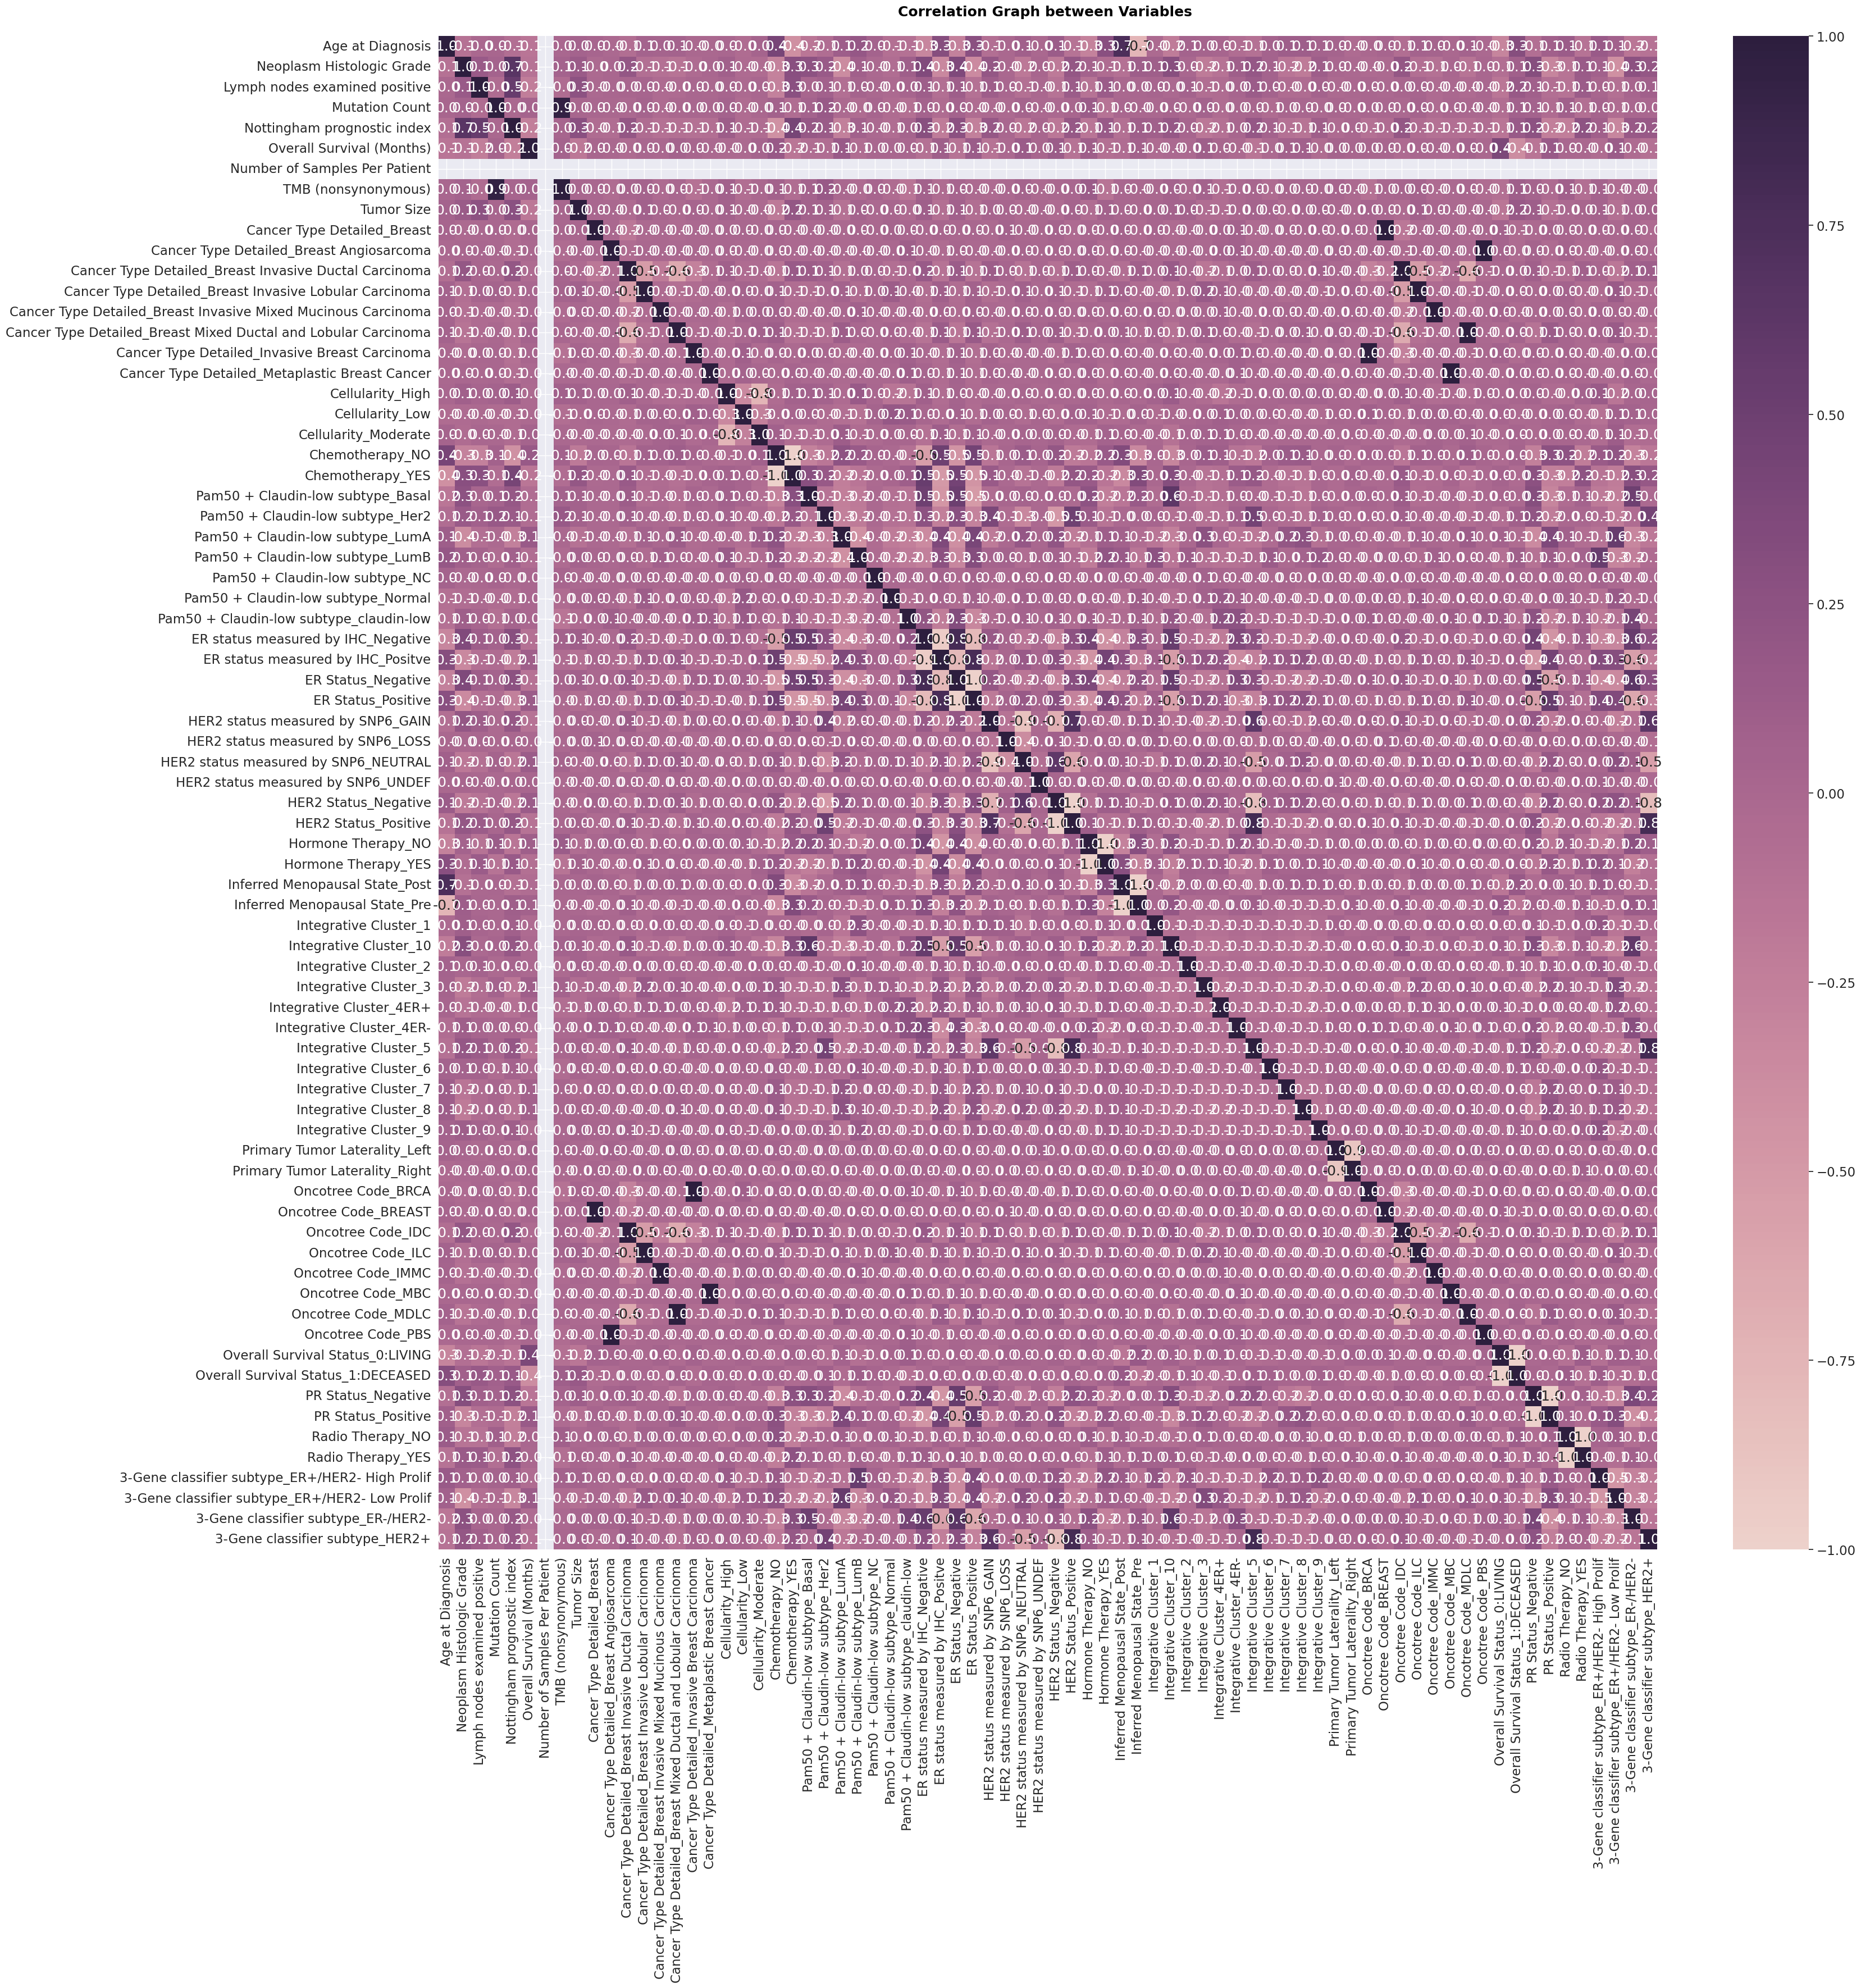

In [268]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Plot heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

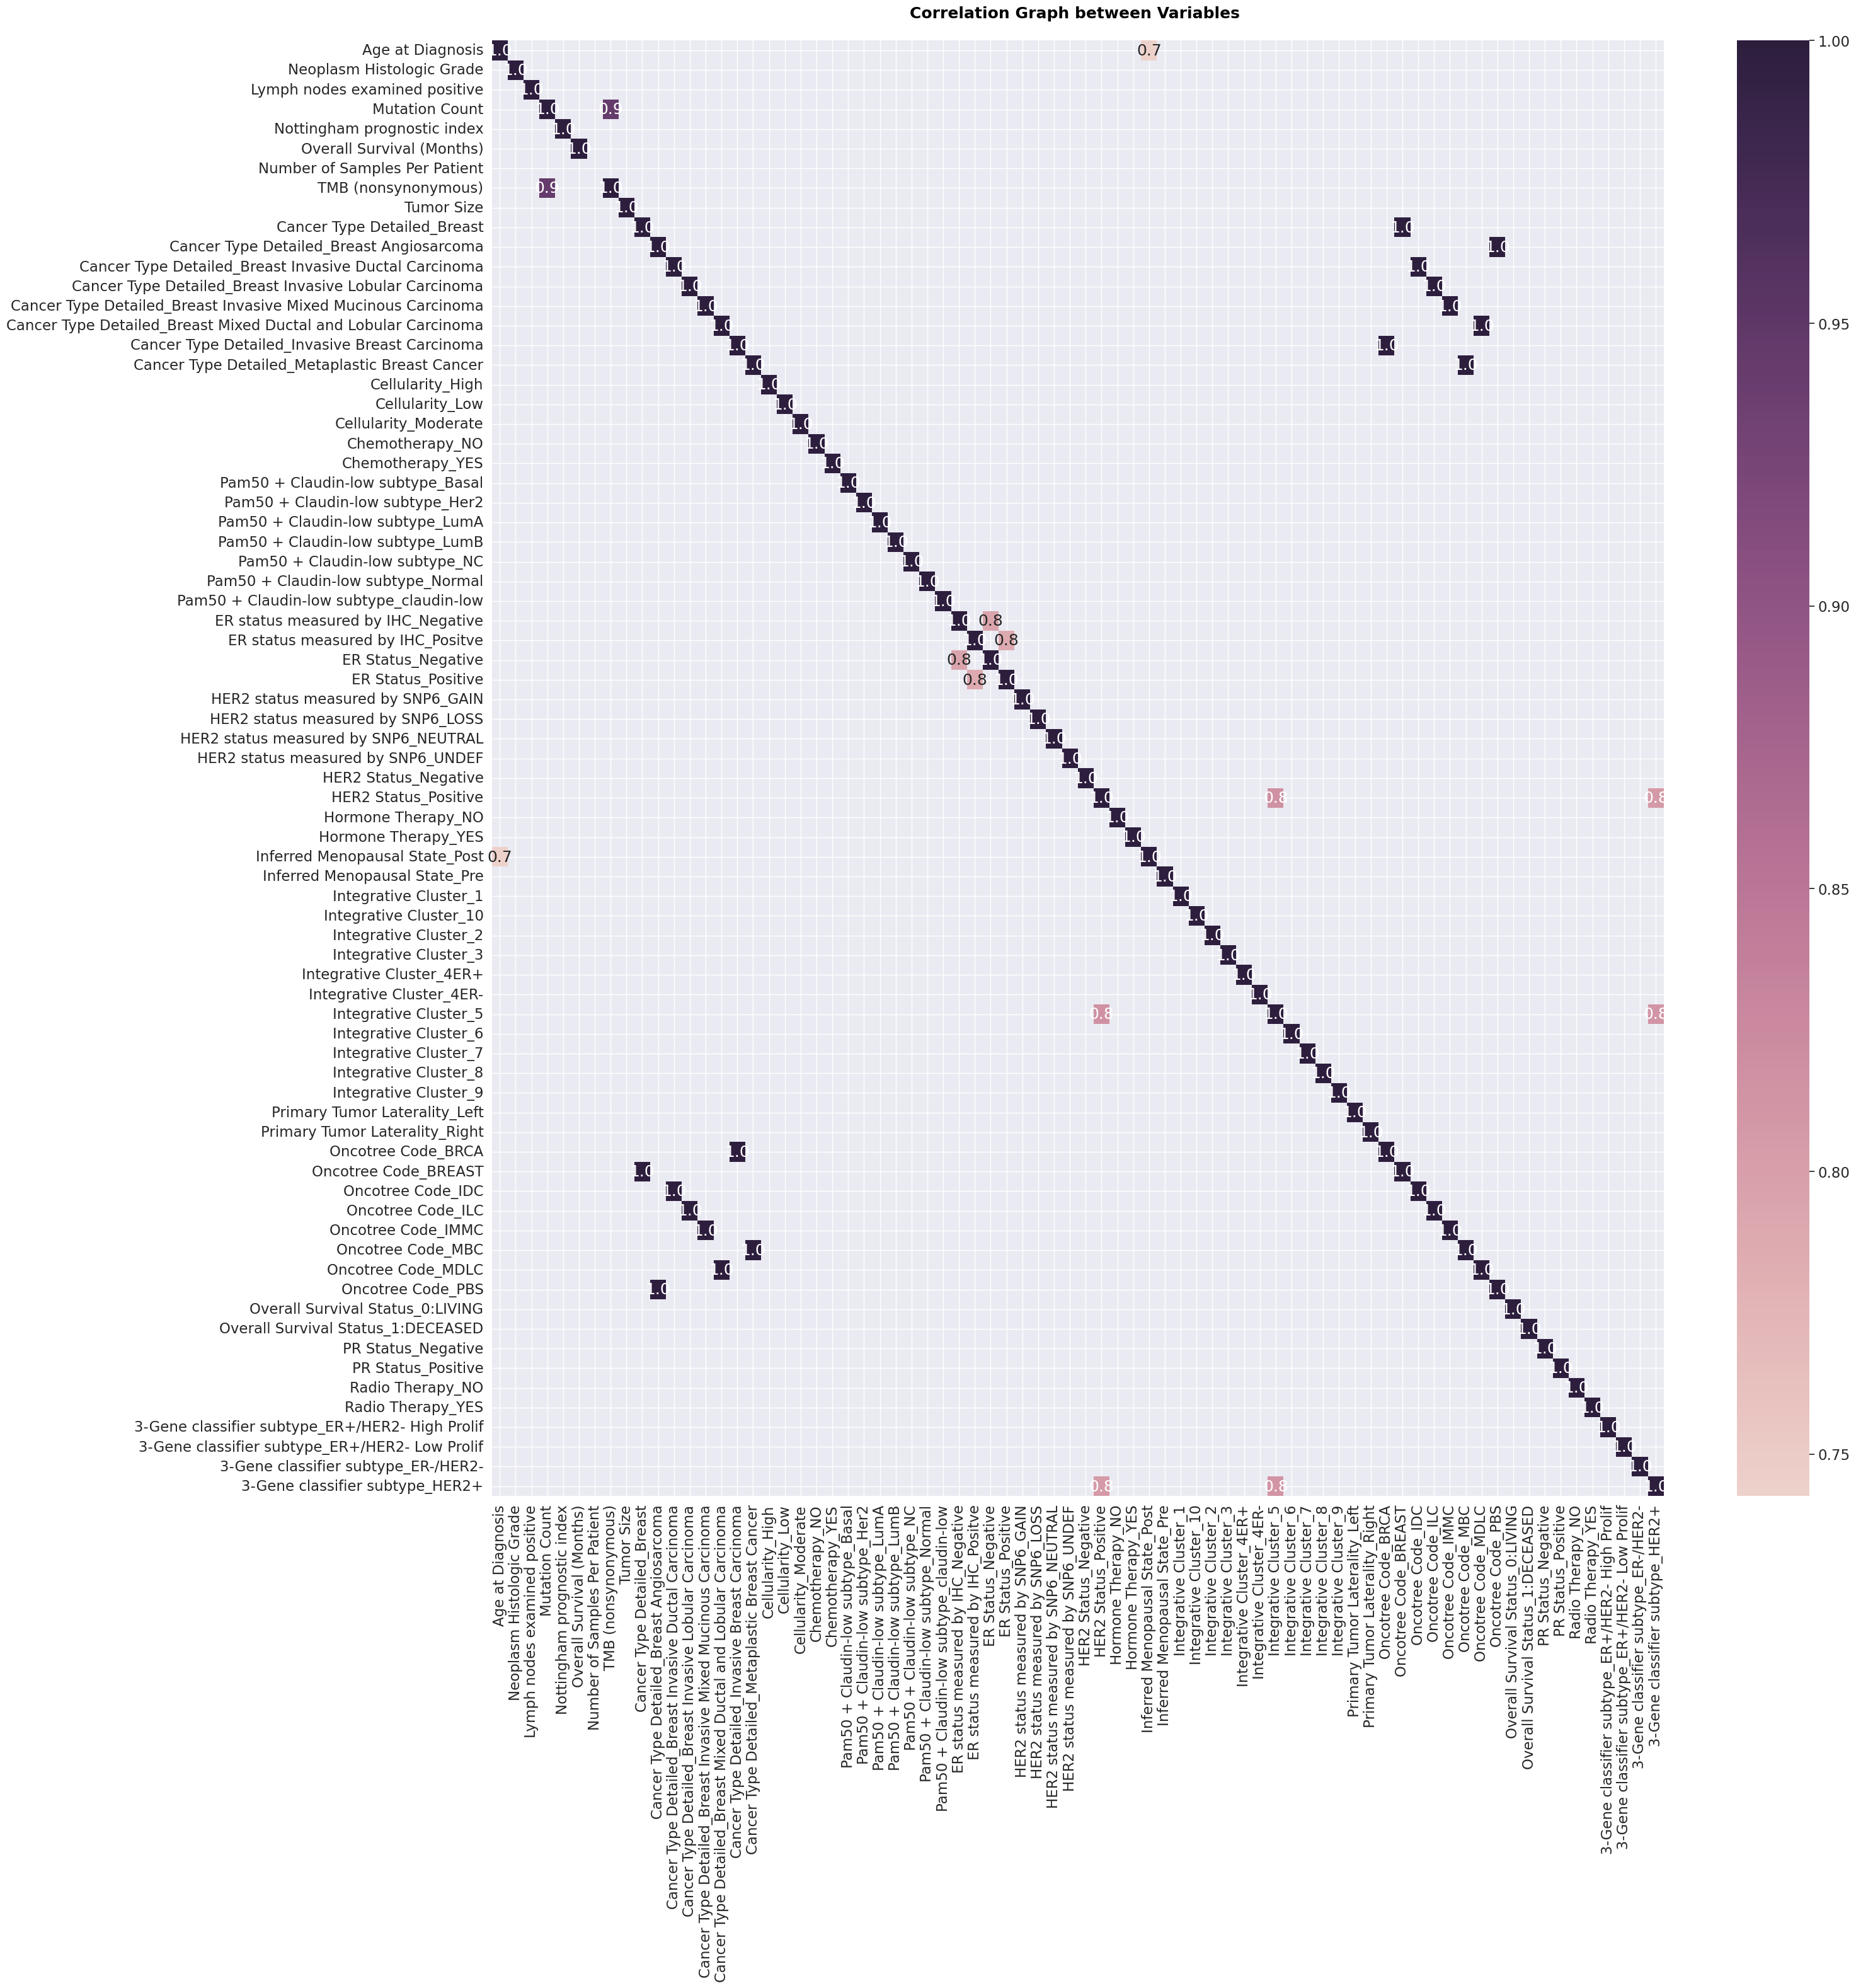

In [269]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

In [270]:
import plotly.express as px
# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
# Extract the first column from the 2D array 'y' and assign it to 'target'

X_df['target'] = y  # Assuming you want the first column of 'y'
  # Create the histogram using the DataFrame and color mapping
histogram_diagnosis = px.histogram(
      X_df,
      x='target',
      color=X_df['target'],  # Map target values to colors
      title='Count Cases',
      text_auto=True,
  )
histogram_diagnosis.show()

In [271]:
import plotly.express as px
fig = px.pie(X_df, names='target', title='Percentage',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

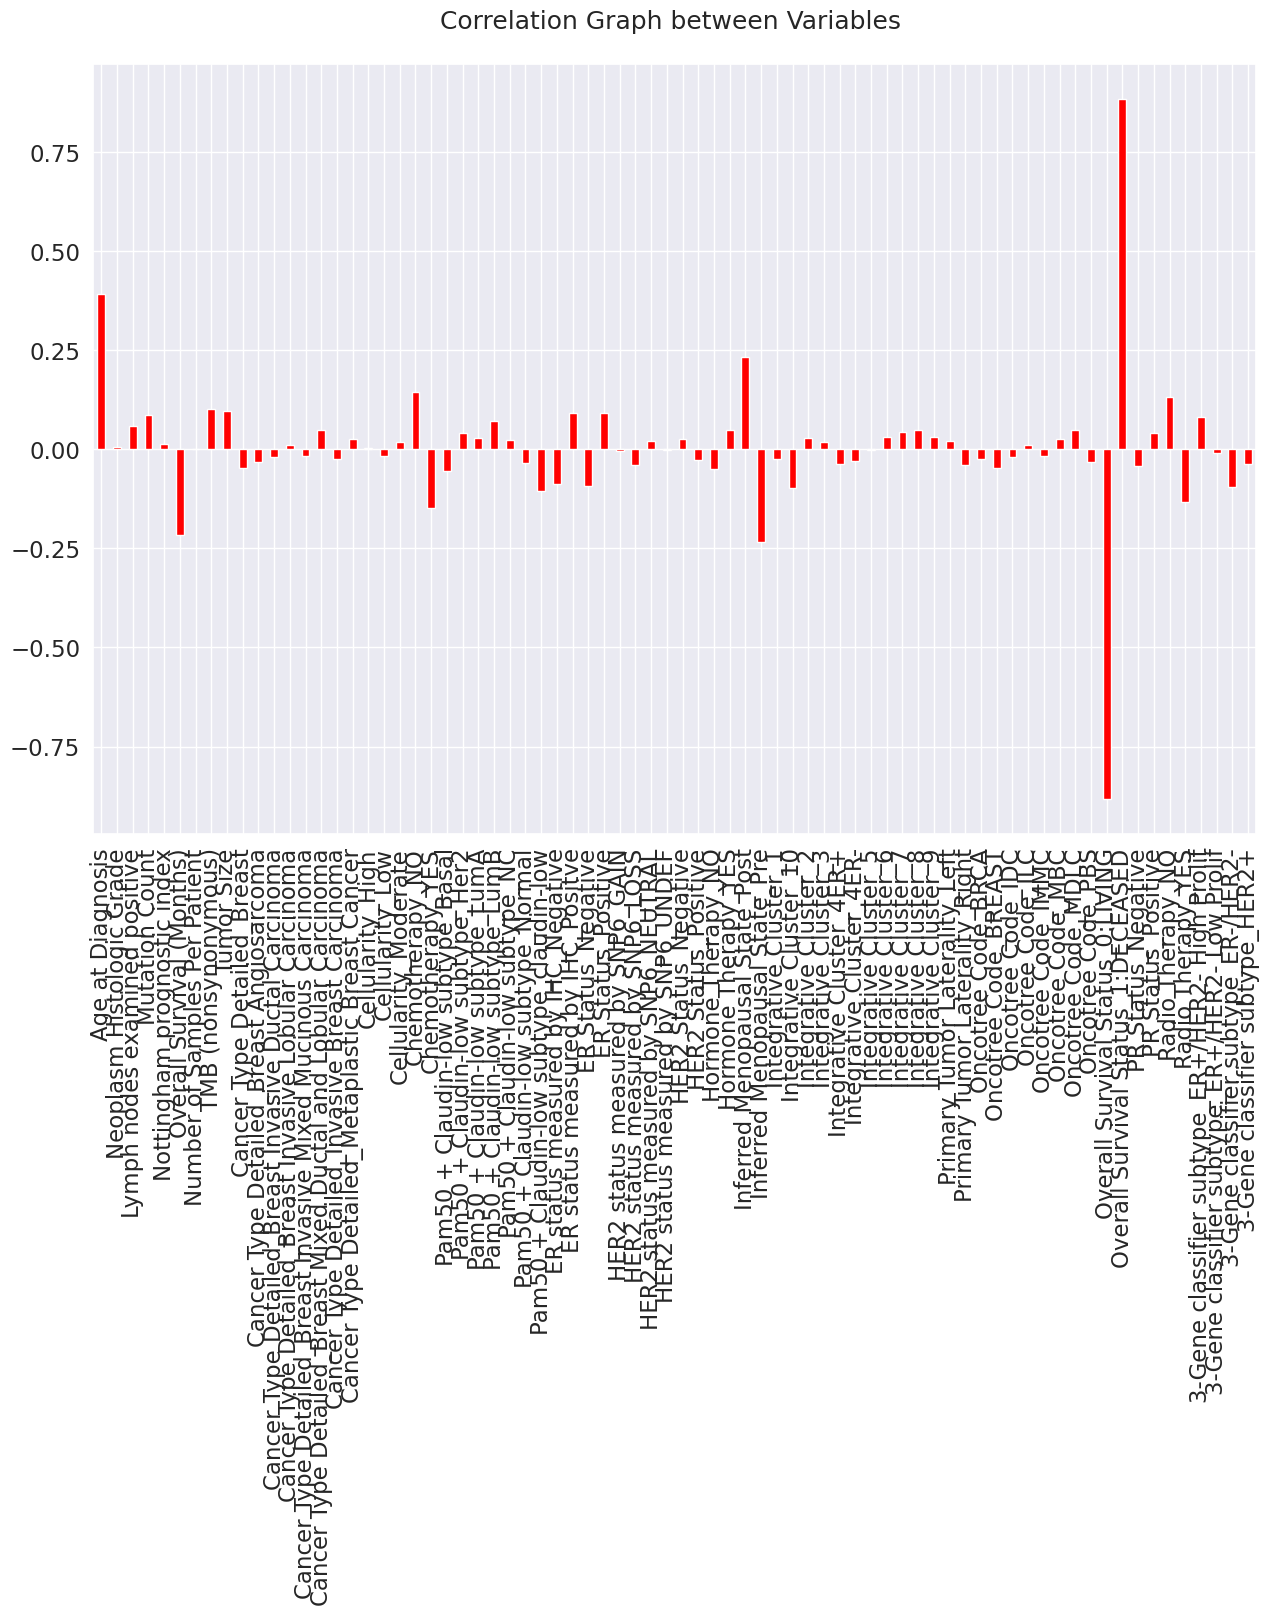

In [272]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

#Model

In [273]:
batch_size=4
epochs=15
clusters=2
tree_model='Random Forest'

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

In [274]:
def encode_target(y, target, num_classes=None):  # Add num_classes argument
    l_encode = LabelEncoder()
    l_encode.fit(y)  # Fit on the actual target values

    # Calculate num_classes if not provided
    if num_classes is None:
        num_classes = len(l_encode.classes_)

    Y = l_encode.transform(y)
    Y = to_categorical(Y, num_classes=num_classes)  # Specify num_classes
    return Y, l_encode  # Return the encoder as well

#Neural Model Multclass

Epoch 1/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4706 - loss: 1.1429
Epoch 2/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6911 - loss: 0.5974
Epoch 3/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7625 - loss: 0.4452
Epoch 4/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7610 - loss: 0.4084
Epoch 5/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8084 - loss: 0.3582
Epoch 6/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7858 - loss: 0.3637
Epoch 7/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8123 - loss: 0.3743
Epoch 8/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8138 - loss: 0.3440
Epoch 9/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8279 - loss: 0.3510
Epoch 10/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8232 - loss: 0.3407
Epoch 11/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8258 - loss: 0.3348
Epoch 12/15
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

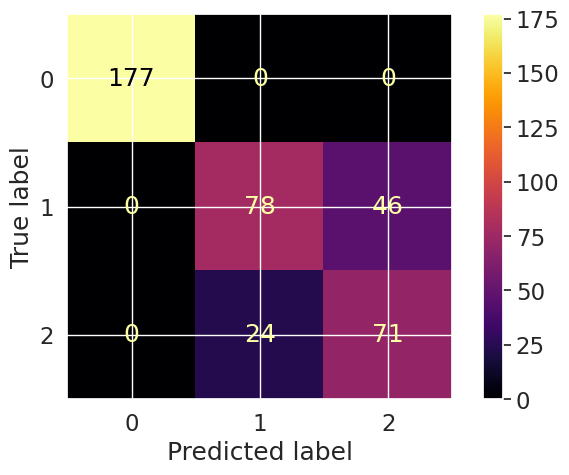

In [275]:
#Neural Network Multclass
# Get the total number of classes from the entire target (y)
all_target_classes = np.unique(np.concatenate([ytrain, ytest]))  # Or use y before splitting
num_classes = len(all_target_classes)

ytrain, l_encode_train = encode_target(ytrain, variavel, num_classes)
ytest, l_encode_test = encode_target(ytest, variavel, num_classes)

processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model_multiclass()

processor_Neuro.models_metrics_neuro_multiclass(model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test)

#Decission Tree MultClass

In [276]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

Best Parameters entropy 5

Model Accuracy: 82.58%

F1 Score: 81.99%

Confussion Matrix


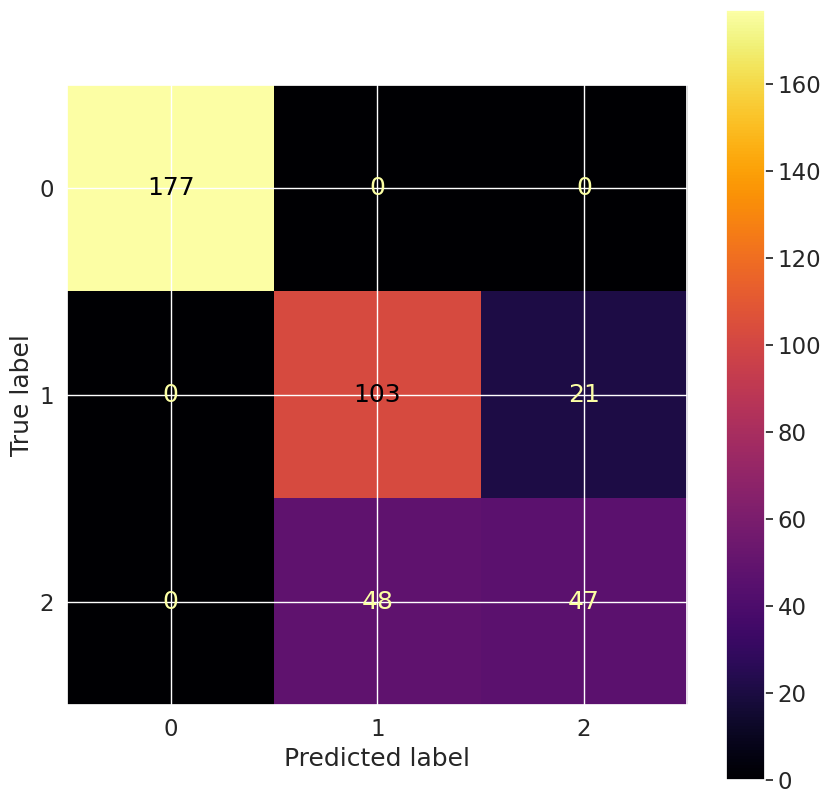


 Feature Importance
importance    74
dtype: int64


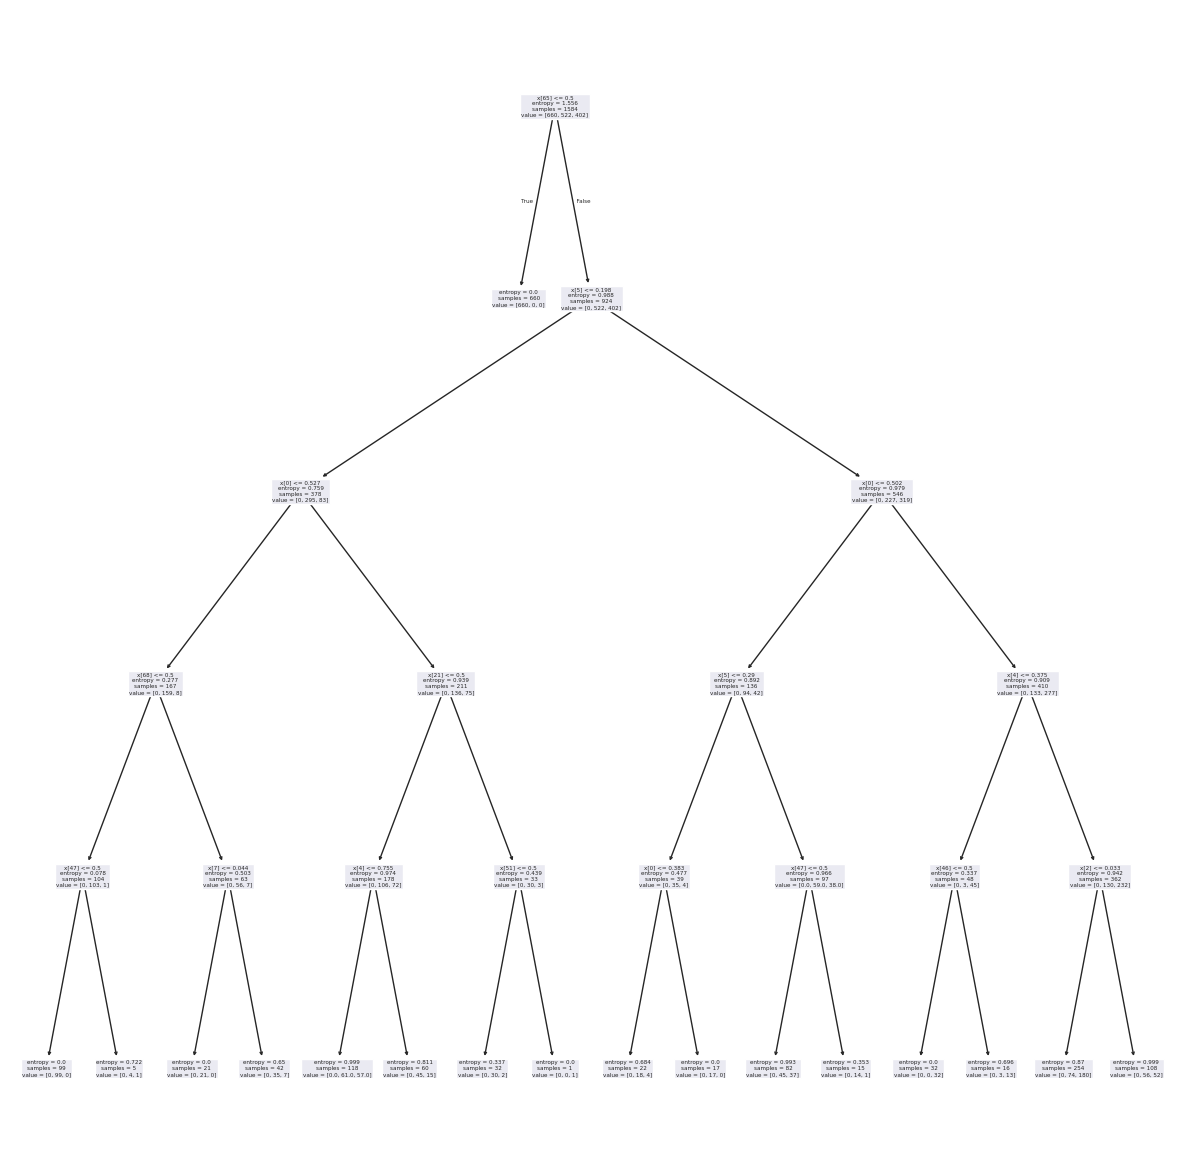

In [277]:
#Decission Tree
type_model='Decission Tree'
processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
processor_decission_tree.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


In [243]:
y_pred=model.predict(Xtest)
y_pred = [np.argmax(v) for v in y_pred]
#df = pd.DataFrame(data=X11, columns=Lista_variaveis)
df2 = pd.DataFrame(data=ytest,columns=['Tarq'])
df3 = pd.DataFrame(data=y_pred,columns=['Pred'])
df2 = pd.concat([df2,df3],axis=1)


In [245]:
df2.to_csv('df_tree.csv', index=False)

#Predict a new dataset

In [216]:
list_to_drop=['Study ID','Patient ID','Sample ID',
              'Type of Breast Surgery','Cancer Type',
              'Tumor Other Histologic Subtype',
              'Relapse Free Status (Months)',
              'Relapse Free Status',
              'Sample Type','Sex','Cohort'
              ]
Dataset_validation.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset_validation.drop(list_to_drop,axis=1,inplace=True)

processor = processing_data(base=Dataset_validation.copy())
variavel='Patients Vital Status'
target='Died of Disease'
type_method='mean'
dummies=list(Dataset_validation.select_dtypes(include=['object']).columns)
dummies.remove('Patients Vital Status')
var_int=['Tumor Purity']
multiclass=True

In [218]:
main_pipeline=Pipeline([
                        #('int_values', FunctionTransformer(processor.int_values,
                        #                    kw_args={'str_var': var_int},
                        #                    validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),
                        ])

# Fit and transform the data using the pipeline
transformed_data1 = main_pipeline.fit_transform(Dataset_validation)
#A=transformed_data['Patients Vital Status']
X1=processor.impute_values(transformed_data1,type_method)
X1,y,Lista_variaveis1=processor.normalize_df(X1,variavel)

#Random Forest MultClass Model

Best Parameters 20 4

Model Accuracy: 81.57%

F1 Score: 81.55%

Confussion Matrix


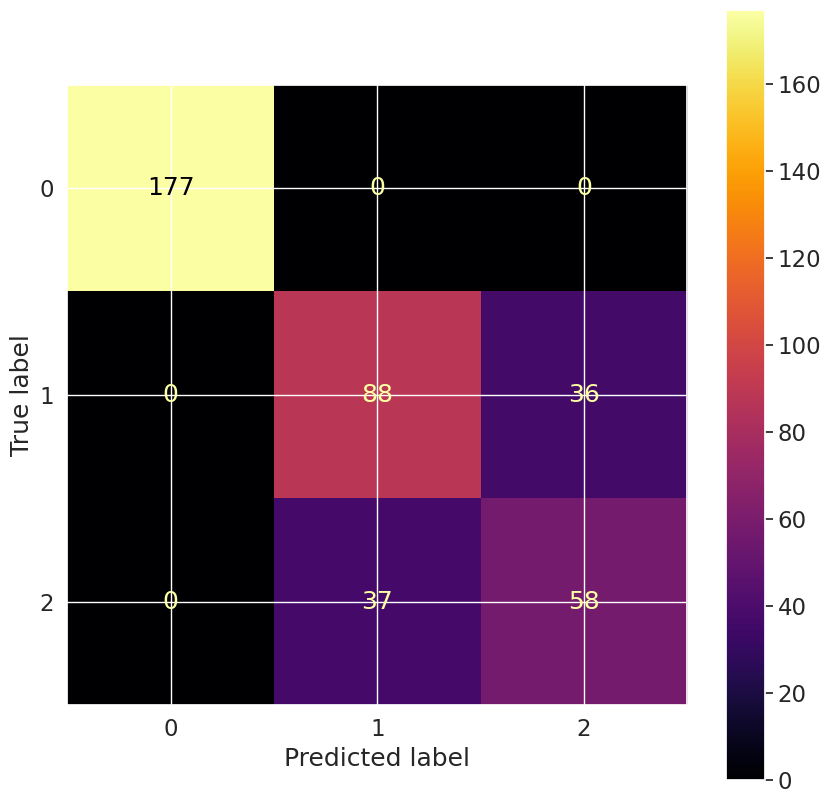


 Feature Importance
importance    74
dtype: int64


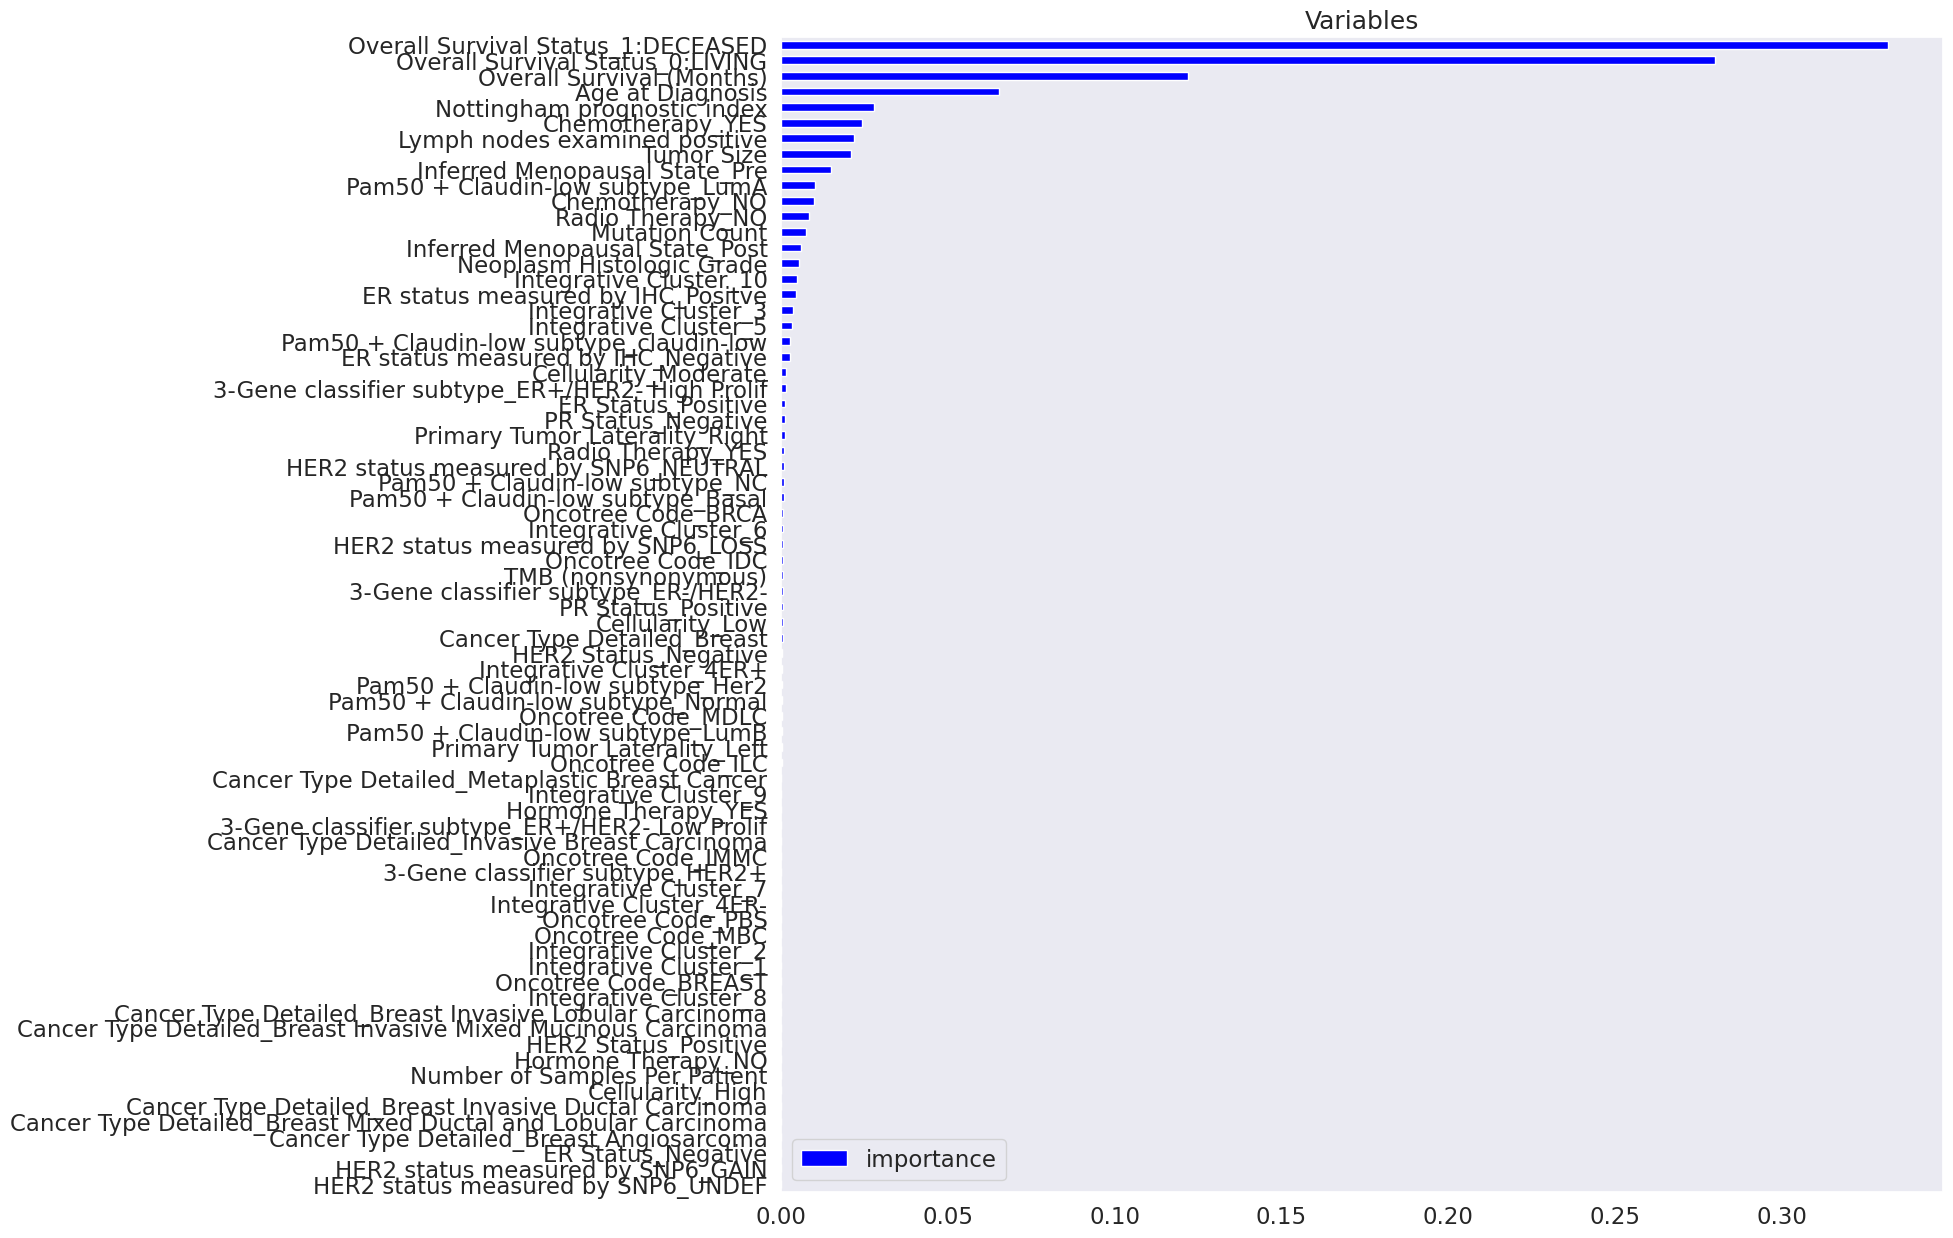

In [278]:
#Random Forest
type_model='Random Forest'
processor_randomf = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


In [252]:
y_pred=model.predict(Xtest)
#X11 = processor.min_max_scaler.inverse_transform(Xtest)
#df = pd.DataFrame(data=X11, columns=Lista_variaveis)
df2 = pd.DataFrame(data=ytest,columns=['Tarq'])
df3 = pd.DataFrame(data=y_pred,columns=['Pred'])
df2 = pd.concat([df2,df3],axis=1)

In [253]:
df2

Tarq  Pred
0       0     0
1       0     0
2       1     1
3       0     0
4       1     1
..    ...   ...
391     1     1
392     1     2
393     1     1
394     1     1
395     0     0

[396 rows x 2 columns]

In [254]:
df2.to_csv('df_tree.csv', index=False)

Best Parameters {'n_neighbors': 5, 'p': 2}

Model Accuracy: 74.24%

F1 Score: 73.56%

Confussion Matrix


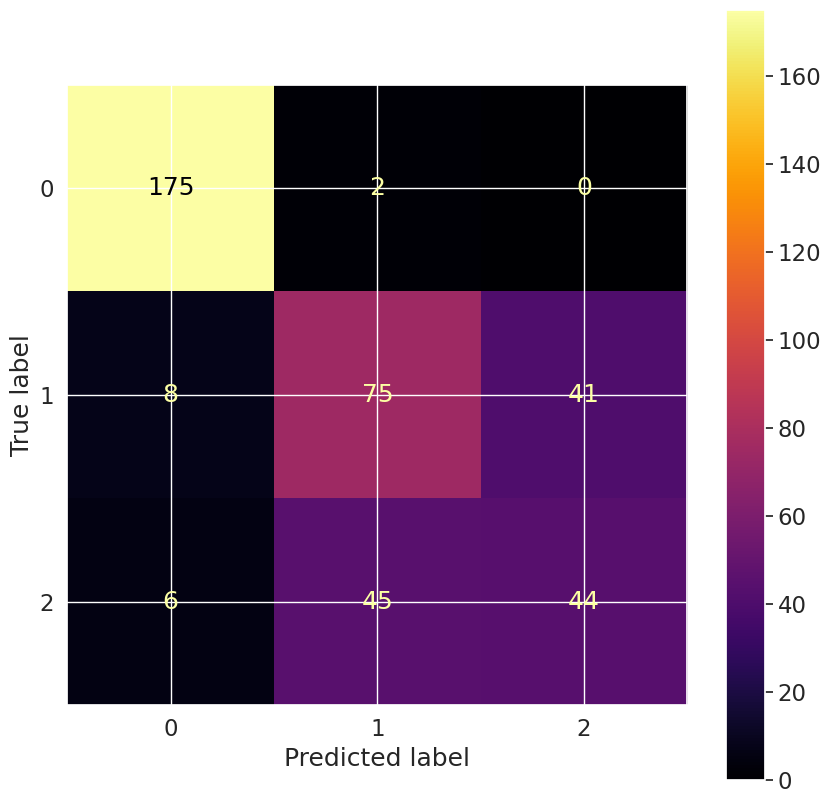


 KNN model does not have feature importance


In [279]:
#KNN Model
type_model='KNN'
processor_knn = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_knn.knn_model()
processor_knn.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)